In [13]:
import torch

# CONTENT_FILE = './input/clp/small1_5second.wav'
# STYLE_FILE = './input/laplus/5second.wav'
CONTENT_FILE = './input/boy/input_boy.wav'
STYLE_FILE = './input/girl/input_girl.wav'
learning_rate = 0.0005

content_weight = 10.0
style_weight = 1.0


print_period = 100
max_epochs = 30000

# If gpu is available               
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

(127421,) (257, 996)
(172398,) (257, 1347)
sample rate: 22050


/home/huci/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


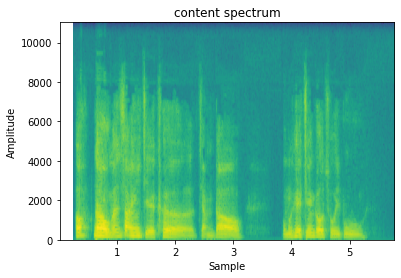

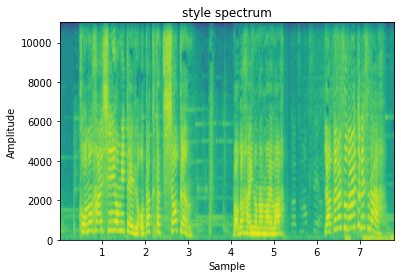

In [2]:

from utils import loadFile, plot_spectrogram_with_raw_signal
from RandomCNN.processing import wav2spectrum, sampleRate
import torch


x_content = loadFile(CONTENT_FILE, sampleRate)
x_style = loadFile(STYLE_FILE, sampleRate)

a_content = wav2spectrum(x_content)
a_style = wav2spectrum(x_style)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(f'sample rate: {sampleRate}')

plot_spectrogram_with_raw_signal(x_content, sampleRate, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style, sampleRate, 'style spectrum')


# Training

In [14]:

from RandomCNN.models import RandomCNN
from RandomCNN.loss import *
import torch.optim as optim


model = RandomCNN()
model.eval()


a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * compute_content_loss(a_C, a_G)
    style_loss = style_weight * compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/30000 content_loss: 0.227223, style_loss: 1407.013550, total_loss: 1407.240723
200/30000 content_loss: 0.234888, style_loss: 1171.190308, total_loss: 1171.425171
300/30000 content_loss: 0.245219, style_loss: 910.796875, total_loss: 911.042114
400/30000 content_loss: 0.256493, style_loss: 683.636353, total_loss: 683.892822
500/30000 content_loss: 0.267971, style_loss: 513.885193, total_loss: 514.153137
600/30000 content_loss: 0.276690, style_loss: 395.997437, total_loss: 396.274139
700/30000 content_loss: 0.282380, style_loss: 316.013702, total_loss: 316.296082
800/30000 content_loss: 0.285978, style_loss: 262.127167, total_loss: 262.413147
900/30000 content_loss: 0.288478, style_loss: 225.619385, total_loss: 225.907867
1000/30000 content_loss: 0.291134, style_loss: 200.067886, total_loss: 200.359024
1100/30000 content_loss: 0.295083, style_loss: 181.230972, total_loss: 181.526062
1200/30000 content_loss: 0.300167, style_loss: 167.024368, total_loss: 167.324539
1300/30000 content_lo

# plot loss curve

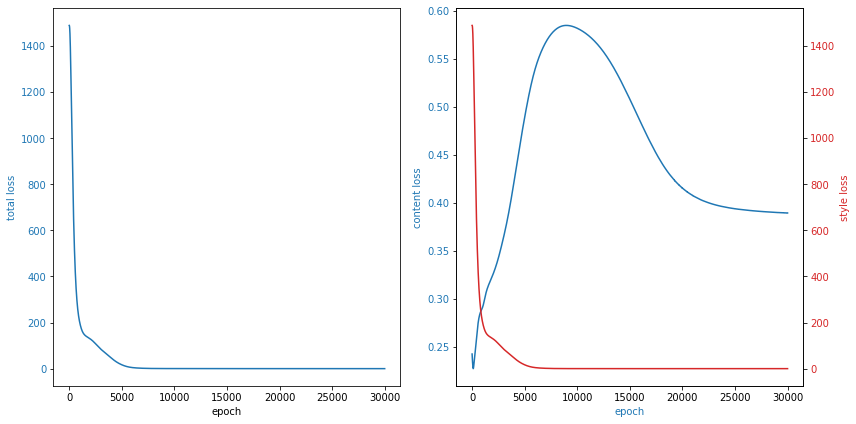

In [15]:
from utils import plot_curve

plot_curve(content_losses, style_losses, losses, same_y_scale=False)


# Save file

(127360,)


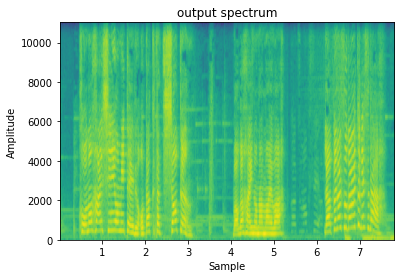

In [16]:

from utils import writeFile, plot_spectrogram_with_raw_signal
from RandomCNN.processing import spectrum2wav, sampleRate
import os

filename = 'randomCNN2.wav'

x = spectrum2wav(gen_spectrum)
print(x.shape)

writeFile(os.path.join('./output/', filename), x, sampleRate)
plot_spectrogram_with_raw_signal(x_style, sampleRate, 'output spectrum')


# 